# Large deformations for points.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi
from scipy.optimize import minimize
from functools import partial

## The failure of smooth splines

Regardless of how smooth a Green's kernel is chosen to be, the simple transformation defined by one landmark point at $x_0$, $x\mapsto x + a K(x - x_0)$, will become not invertable for some value of $a \in \mathbb{R}^d$ (for $d=1,2$ or $3$ as appropriate).

Let $\phi(x) = x + v(x)$, where $v(x) =  a K(x - x_0)$. 

#### Invertable mappings have nonzero determinant of Jacobian everywhere

This is implied by the inverse function theorem https://en.wikipedia.org/wiki/Inverse_function_theorem


According to implicit function theory, $\partial_x \phi^{-1}(x) = [\partial_x ( x + v(x))]^{-1} = [Id + a \partial_x K(x-x_0)]^{-1} $, Hence, in order to get a smooth landmark mapping, we need $\phi^{-1}(x)$ to be smooth, which implies $Id + a \partial_x K(x-x_0)$ should be invertible. 

#### 1D example 
To see this, consider the simplest possible landmark matching problem.We will pose 1d problem with a Gaussian kernel, and only one landmark.  We look at the determinant of Jacobian of the mapping, which is just the derivative in this case.


\begin{align*}
\frac{d}{dx} (x + a \exp( -|x - x_0|^2/2\sigma^2)) &= 1 - a\sigma^2 (x - x_0) \exp( -|x - x_0|^2/2\sigma^2)
\end{align*}

Consider the point $x = x_0 + 1$.  The expression becomes $1 - a\sigma^2 \exp(-1/2\sigma^2)$.  This is zero for $a = \frac{1}{\sigma^2 \exp(-1/2\sigma^2)}$, and negative for any larger $a$.

Regardless of how smooth $K$ is, we will run into this problem for large deformations.

Notice however that for small $a$, the determinant of Jacobian becomes arbitrarily close to 1.  Small enough deformations are always invertable with smooth kernels.

This example allows us to look at the analytical formula.  Below we will show examples of this behaviour for data in 2D.


<IPython.core.display.Javascript object>


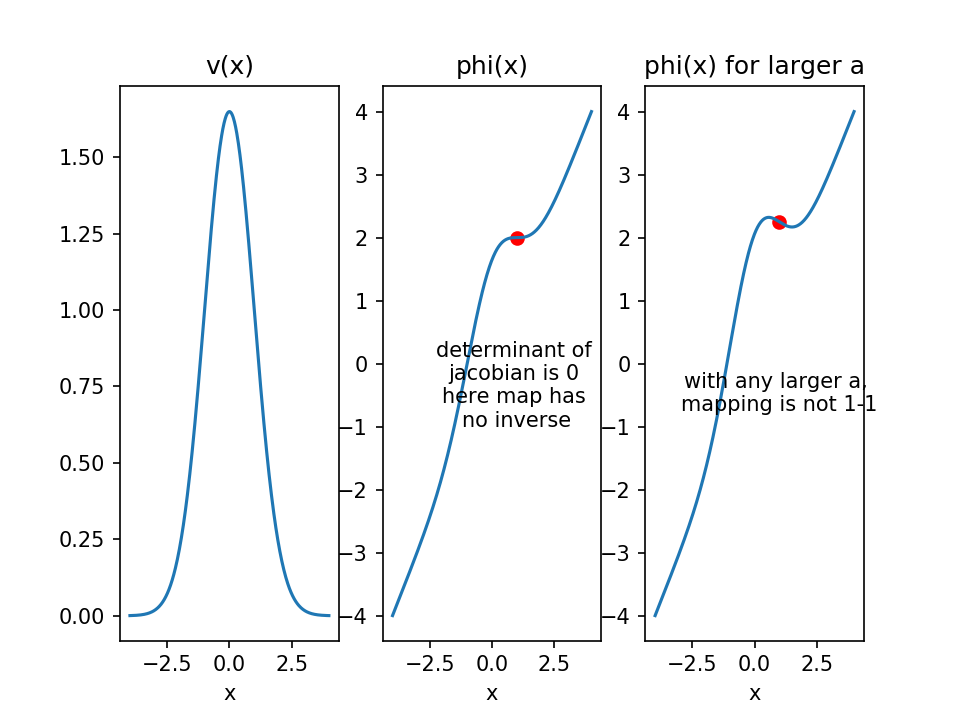

In [2]:
# 1D example
sigma = 1.0
x = np.linspace(-4,4,500)
x0 = 0.0

a = 1.0/(sigma**2 * np.exp(-1.0/2.0/sigma**2))
v = a * np.exp( -(x - x0)**2/2.0/sigma**2 )

f,ax = plt.subplots(1,3)
ax[0].plot(x,v)
ax[0].set_xlabel('x')
ax[0].set_title('v(x)')
ax[1].plot(x,x+v)
ax[1].set_xlabel('x')
ax[1].set_title('phi(x)')
ax[1].scatter(1,1 + a * np.exp(-(1)**2/2.0/sigma**2),color='r')
ax[1].text(1,1 + a * np.exp(-(1)**2/2.0/sigma**2)-3, 'determinant of \njacobian is 0 \nhere map has \nno inverse', horizontalalignment='center')

# now show a bit bigger
a_ = a*1.25
v_ = a_ * np.exp( -(x - x0)**2/2.0/sigma**2 )
ax[2].plot(x,x+v_)
ax[2].set_xlabel('x')
ax[2].set_title('phi(x) for larger a')
ax[2].scatter(1,1 + a_ * np.exp(-(1)**2/2.0/sigma**2),color='r')
ax[2].text(1,1 + a_ * np.exp(-(1)**2/2.0/sigma**2)-3, 'with any larger a, \nmapping is not 1-1', horizontalalignment='center')

plt.show()

In [3]:
# define kernel to remove some redundancy in our code
# use a Gaussian kernel
sig = 1
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*sig**2))

# derative of kernel
def k_d1(x,y):
    v = np.exp(-np.sum((x-y)**2)/(2.0*sig**2))/(sig**2)
    return v

#### 2D example:
Now let's see 2D example, let $a=[c,0]^T$ with $c=1,2,4$

<IPython.core.display.Javascript object>


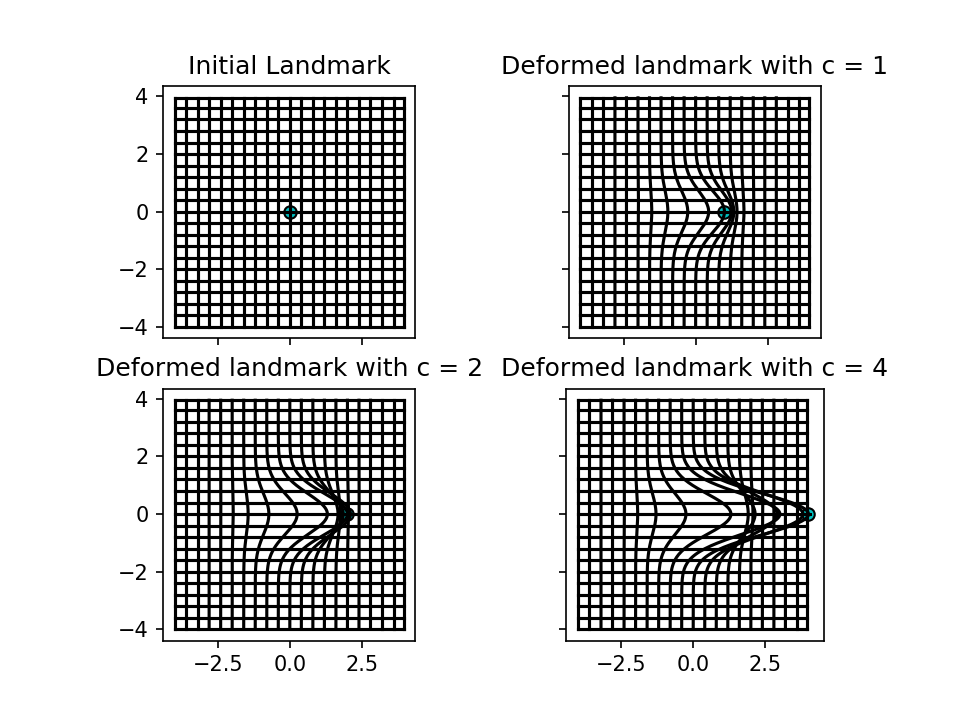

In [4]:
# 2D example
X = np.array([[0.0],[0.0]])
# print(X)
# below is just plotting figure
f,ax = plt.subplots(2,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0][0],rstride=stride,cstride=stride)
hx = ax[0][0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0][0].set_aspect('equal')
ax[0][0].set_title('Initial Landmark')


# For c = 1;
c=1.0
a = np.array([c,0])

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        phiX0[i,j] += a[0]*k(p,X[:])
        phiX1[i,j] += a[1]*k(p,X[:])
# print(phiX0.shape)
# deform point x
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
X_deform0 += a[0]*k(X,X)
X_deform1 += a[1]*k(X,X)
X_deform = np.array([X_deform0, X_deform1])



ss.plot_grid(phiX0,phiX1,ax=ax[0][1],rstride=stride,cstride=stride)
hx = ax[0][1].scatter(X_deform0,X_deform1,color='c',edgecolor='k')
ax[0][1].set_aspect('equal')
ax[0][1].set_title('Deformed landmark with c = 1')


# For c = 2;
c=2.0
a = np.array([c,0])

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        phiX0[i,j] += a[0]*k(p,X[:])
        phiX1[i,j] += a[1]*k(p,X[:])
# print(phiX0.shape)
# deform point x
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
X_deform0 += a[0]*k(X,X)
X_deform1 += a[1]*k(X,X)
X_deform = np.array([X_deform0, X_deform1])



ss.plot_grid(phiX0,phiX1,ax=ax[1][0],rstride=stride,cstride=stride)
hx = ax[1][0].scatter(X_deform0,X_deform1,color='c',edgecolor='k')
ax[1][0].set_aspect('equal')
ax[1][0].set_title('Deformed landmark with c = 2')



# For c = 4;
c=4.0
a = np.array([c,0])

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        phiX0[i,j] += a[0]*k(p,X[:])
        phiX1[i,j] += a[1]*k(p,X[:])
# print(phiX0.shape)
# deform point x
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
X_deform0 += a[0]*k(X,X)
X_deform1 += a[1]*k(X,X)
X_deform = np.array([X_deform0, X_deform1])



ss.plot_grid(phiX0,phiX1,ax=ax[1][1],rstride=stride,cstride=stride)
hx = ax[1][1].scatter(X_deform0,X_deform1,color='c',edgecolor='k')
ax[1][1].set_aspect('equal')
ax[1][1].set_title('Deformed landmark with c = 4')

plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)

plt.show()


## A better solution

Instead of letting $v$ code a displacement field, we consider $v_t$ as a function of time for $t \in [0,1]$, and let it encode a flow.  That is, if we have a set of landmark points called $q^i$ for $i \in \{1,\ldots, N\}$
\begin{align*}
\frac{d}{dt} q^i_t = v_t(q^i_t)
\end{align*}

As before, we will write $v$ in the form of
\begin{align*}
v_t(x) = \sum_{i = 1}^N K(x,q^i_t)a_t^i
\end{align*}
for a set of parameters $a_t$ which we will call momentum.

We find the optimal parameters $a^i_t$ by minimizing a cost function, which is a sum of a regularization term, and an accuracy term.  If our target landmarks are called $Y^i$, our cost function will be written as
\begin{align*}
E = \frac{1}{2} \int_0^1 a^{iT}_t K(q^i_t,q^j_t)a^{j}_t dt + \frac{1}{2 \sigma^2} \sum_{i = 1}^N |q^i_1 - Y^i|^2
\end{align*}

The dynamics above will be enforced using a Lagrange multiplier, or co-state, which we call $p^i$.  This gives us a Lagrangian to optimize.
\begin{align*}
L &= E + \int_0^1 p^{iT}_t (\frac{d}{dt}q^i_t - v_t(q_t^i))dt
\end{align*}

This constrained optimization problem can be solved using variational methods.  It is included in the cell below for completeness, but we will skip it in this lecture.




## Derivation of gradient descent algorithm using Hamiltonian principles

TO DO


## Gradient descent algorithm

Our algorithm proceeds as follows.

1. Flow the state forward using current guess of $a$.

2. Compute the endpoint cost and the regularization cost.

3. Initialize the costate $p^i_1 = \frac{-1}{\sigma^2}(q_1^i - Y^i)$

4. Flow the costate backwards from time 1 to 0 using the equation

5. Update our current guess of $a$ according to the rule $a^i_t \mapsto a^i_t - \epsilon (a^i_t - p^i_t)$ for small step size $\epsilon$ 

6. Repeat steps 1 to 5 until energy has been reduced sufficiently (or other stopping condition)


Below we code all the functions that were described in this section.

In [5]:
# Define all functions I will use in this tutorial

# compute N by N Kernal Matrix
def K_mat(x,y):
    K = np.empty((len(x[0]),len(y[0])))
#     print(K.shape)
    for i in range(len(x[1])):
        for j in range(len(y[1])):
            K[i,j] = k(x[:,i],y[:,j])
    return K
# print(K_mat(X,Y))


# Compute the d by N by N derivative of Kernal Matrix, 
# for d the dimension of our points
def K_d1_mat(x,y,n):
    d,N = x.shape
    Kd = np.zeros((d,N,N))
#     print(K.shape)
    for i in range(N):
        Kd[:,i,n] = k_d1(x[:,i],y[:,n])
    for j in range(N):   
        Kd[:,n,j] = k_d1(x[:,n],y[:,j])
    return Kd


# Compute flows
# this returns a 3 by N by T+1 array
def Compute_phi_forward(x0,a):
    d,N,T = a.shape
    dt = 1.0/T
    Z = np.zeros((d,N,T+1))
    Z[:,:,0] = x0
    for t in range(T):
        Kzz = K_mat(Z[:,:,t],Z[:,:,t])
        for i in range(d):
            # we update using euler's method, 
            # find the time derivative and add it, multiplying by dt
            # i.e. displacement = speed times time
            Zdot = np.dot(Kzz,a[i,:,t])
            Z[i,:,t+1] = Z[i,:,t] + Zdot*dt
    return Z

# p(T-1) = -dG(z(T))
# this is just the derivative of our sum of square error matching function
# this is a d by N array
def Compute_final_costate(z_end,Y,c):    
    P_final = -2.0*c*(z_end-Y)
    return P_final

# this function flows the costate backward from the endpoint of the flow back to the start
# This is a d by N by T array
def Compute_phi_backward(P_final,Z,a):
    d,N,T = a.shape
    dt = 1.0/T
    P_inv = np.zeros((d,N,T))
    P_inv[:,:,T-1] = P_final    
    for t in range(T-1,0,-1):
        for n in range(N):
            dKzz = K_d1_mat(Z[:,:,t],Z[:,:,t],n)
            for i in range(d):
                # we use Euler's method again, calcluate the speed
                P_inv_dot = -np.dot(np.dot(dKzz[i,:,:],a[i,:,t]),(a[i,:,t]-P_inv[i,:,t]))
                P_inv[i,n,t-1] = P_inv[i,n,t] - P_inv_dot*dt # note since we are flowing backwards, we have a minus sign
    return P_inv

# the derivative of our Augmented cost function with respect to a
# it is a d by N by T array
def Compute_dF_a(a,P_inv,Z):
    d,N,T = a.shape
    da = np.zeros((d,N,T))
    
    for t in range(T):
        Kzz = K_mat(Z[:,:,t],Z[:,:,t])
        for i in range(d):
            da[i,:,t] = (a[i,:,t]-P_inv[i,:,t])/T
    return da


## Examples

Let's see two 2-D LDDMM landmark examples:

(a) a set of landmarks in a circle are mapping to an ellipse.

(b) a set of landmarks in a circle are mapping to an ellipse, except for the first lankmark is mapped to the point [1,2]^T. This case exhibites singularities and ambiguities. 


<IPython.core.display.Javascript object>


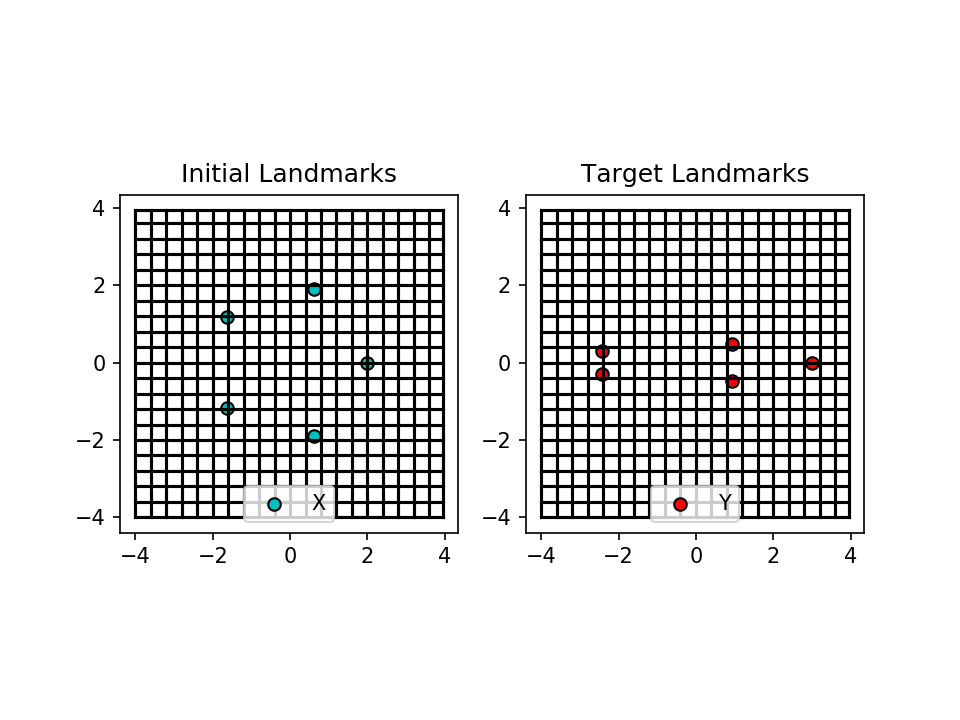

In [6]:
N = 5
n = np.arange(0,N,1)
# Example (a)
# X = np.array([np.cos(2*n*np.pi/N),np.sin(2*n*np.pi/N)])
# Y = np.array([-1+2*n/N,-1+2*n/N])

# Example (b)
X = np.array([2*np.cos(2*n*np.pi/N),2*np.sin(2*n*np.pi/N)])
Y = np.array([3*np.cos(2*n*np.pi/N),0.5*np.sin(2*n*np.pi/N)])
# print(X)
# print(Y)

# below is just plotting figures
f,ax = plt.subplots(1,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0],rstride=stride,cstride=stride)
hx = ax[0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0].set_aspect('equal')
ax[0].legend([hx],['X'])
ax[0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[1],rstride=stride,cstride=stride)
hy = ax[1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[1].set_aspect('equal')
ax[1].legend([hy],['Y'])
ax[1].set_title('Target Landmarks')
plt.show()

## Spline method: Before we use LDDMM, let's do spline method again.

<IPython.core.display.Javascript object>


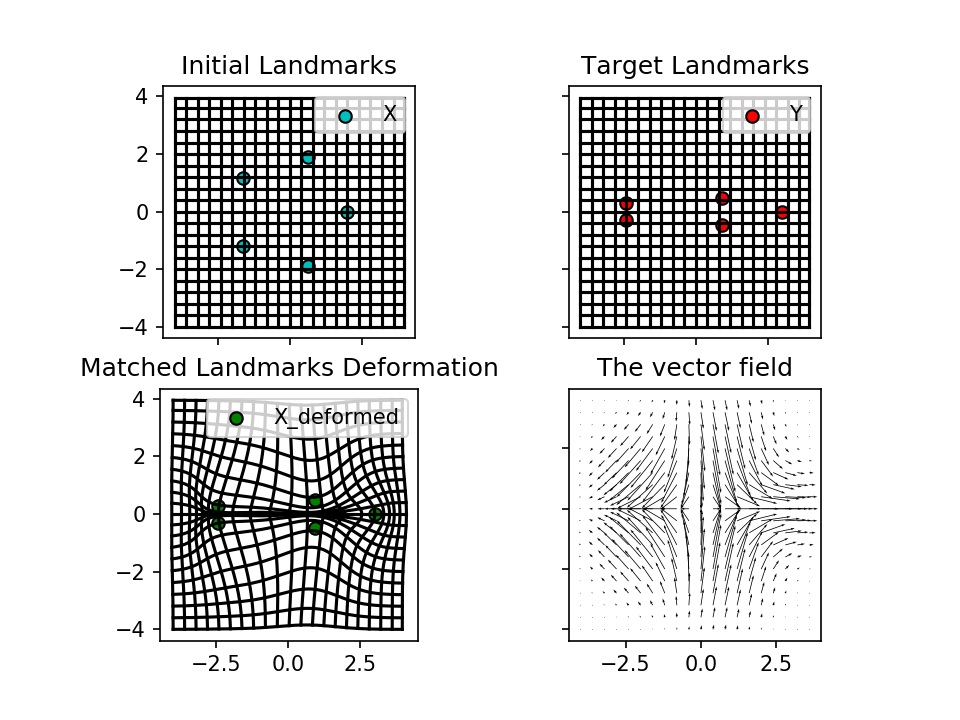

In [7]:
# N: number of landmarks
N = X.shape[1]

# Compute a kernel matrix
K = np.empty((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(X[:,i],X[:,j])
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()
# print('Lambda :', Lambda)

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        for k_ in range(N):
            phiX0[i,j] += Lambda[0,k_]*k(p,X[:,k_])
            phiX1[i,j] += Lambda[1,k_]*k(p,X[:,k_])
# print(phiX0.shape)

# deform landmarks to target
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
for i in range(N):
    p = np.array([X[0,i],X[1,i]])
    for j in range(N):
        X_deform0[i] += Lambda[0,j]*k(p,X[:,j])
        X_deform1[i] += Lambda[1,j]*k(p,X[:,j])
X_deform = np.array([X_deform0, X_deform1])
# print(X_deform.shape)

f,ax = plt.subplots(2,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

ss.plot_grid(phiX0,phiX1,ax=ax[1,0],rstride=stride,cstride=stride)
hx_deform = ax[1,0].scatter(X_deform[0,:],X_deform[1,:],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hx_deform],['X_deformed'],loc="upper right")
ax[1,0].set_title('Matched Landmarks Deformation')

ax[1,1].quiver(X0[::stride,::stride],X1[::stride,::stride],phiX0[::stride,::stride]-X0[::stride,::stride],
             phiX1[::stride,::stride]-X1[::stride,::stride],
             scale=stride)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('The vector field')

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

# Note from the bottom left figure that we have a non invertible transformation!

## Do Landmark LDDMM for the first example 

In [8]:
# Let's optimize for the momentum variables a using gradient descent

# parameters
sigma = 0.25
niter = 1000
epsilon = 2.0e-2

# initialize
T = 10 # Number of steps 
d,N = X.shape
a = np.zeros((d,N,T))
c = 1.0/2/sigma**2 # weighting
# make cost function only depends on momentum a
# print('Initial momentum :')
# print(a)

for it in range(niter):
    ER = 0.0
    # Compute forward propagation
    Z = Compute_phi_forward(X,a)
    
    # Compute the final co-state by matching to target
    P_final = Compute_final_costate(Z[:,:,T],Y,c)
#     print(P_final
#     err = Y - Z[:,:,T]
#     EM = np.sum(err**2/(2.0*sigma**2))
#     print(EM)
    
    # Compute backward propagation
    P_inv = Compute_phi_backward(P_final,Z,a)
        
    # Compute the derivative of cost function over a
    da = Compute_dF_a(a,P_inv,Z)
    
    # Update a 
    a += -epsilon*da
    


In [9]:
# Here we will compute some flow variables for visualization

# Compute deformed landmarks over t
Z = Compute_phi_forward(X,a)
# print(Z)

# Compute deformed grid flow over t
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0_t = np.array(X0)
phiX1_t = np.array(X1)

for t in range(T):
    for i in range(len(x0)):
        for j in range(len(x1)):
            # this point
            p = np.array([phiX0_t[i,j],phiX1_t[i,j]])
            for k_ in range(N):
                phiX0_t[i,j] += a[0,k_,t]*k(p,Z[:,k_,t])/T
                phiX1_t[i,j] += a[1,k_,t]*k(p,Z[:,k_,t])/T

<IPython.core.display.Javascript object>


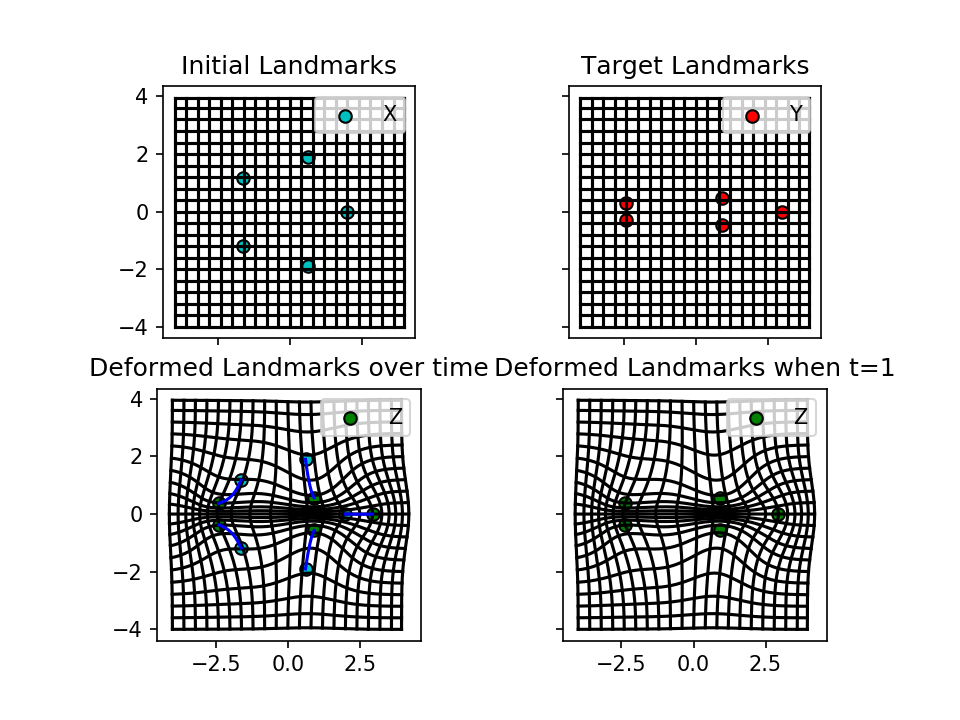

In [10]:
# now we will make a visualization just like for the spline case

f,ax = plt.subplots(2,2)
# plot subject landmarks at t=0 (initial) 
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

# plot target landmarks
ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

# plot deformed subject landmarks trajectory
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,0],rstride=stride,cstride=stride) 
hx = ax[1,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
for i in range(N):
    hz = ax[1,0].plot(Z[0,i,:],Z[1,i,:],color='b')
hz = ax[1,0].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hz],['Z'],loc="upper right")
ax[1,0].set_title('Deformed Landmarks over time')

# plot deformed subjectlandmarks at t=T (final)
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,1],rstride=stride,cstride=stride) 
hz = ax[1,1].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,1].set_aspect('equal')
ax[1,1].legend([hz],['Z'],loc="upper right")
ax[1,1].set_title('Deformed Landmarks when t=1')

plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

# Notice at the bottom left, the transformation is still invertible
# Notice that the landmarks flow along curved trajectories

## Case 2 
A set of landmarks in a circle are mapping to an ellipse, except for the first lankmark is mapped to the (1,2). This case exhibites singularities and ambiguities. 

<IPython.core.display.Javascript object>


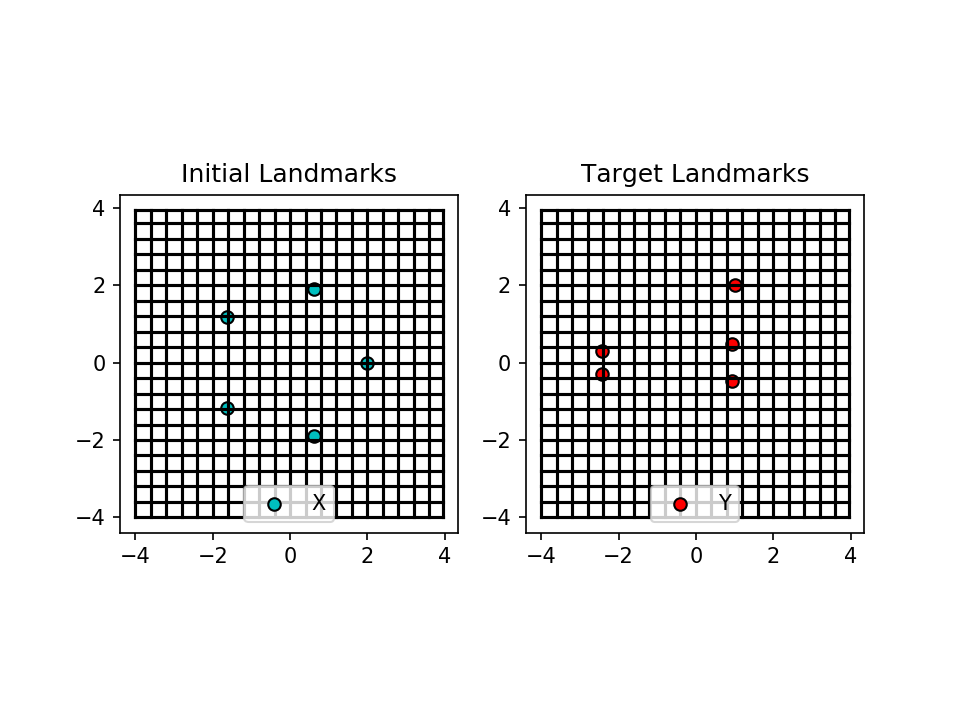

In [11]:
# Now set to different target landmarks
N = 5
n = np.arange(0,N,1)
# Example (a)
# X = np.array([np.cos(2*n*np.pi/N),np.sin(2*n*np.pi/N)])
# Y = np.array([-1+2*n/N,-1+2*n/N])

# Example (b)
X = np.array([2*np.cos(2*n*np.pi/N),2*np.sin(2*n*np.pi/N)])
Y = np.array([3*np.cos(2*n*np.pi/N),0.5*np.sin(2*n*np.pi/N)])
Y[0,0] = 1
Y[1,0] = 2

f,ax = plt.subplots(1,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0],rstride=stride,cstride=stride)
hx = ax[0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0].set_aspect('equal')
ax[0].legend([hx],['X'])
ax[0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[1],rstride=stride,cstride=stride)
hy = ax[1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[1].set_aspect('equal')
ax[1].legend([hy],['Y'])
ax[1].set_title('Target Landmarks')
plt.show()

### Do the second case by spline method:

<IPython.core.display.Javascript object>


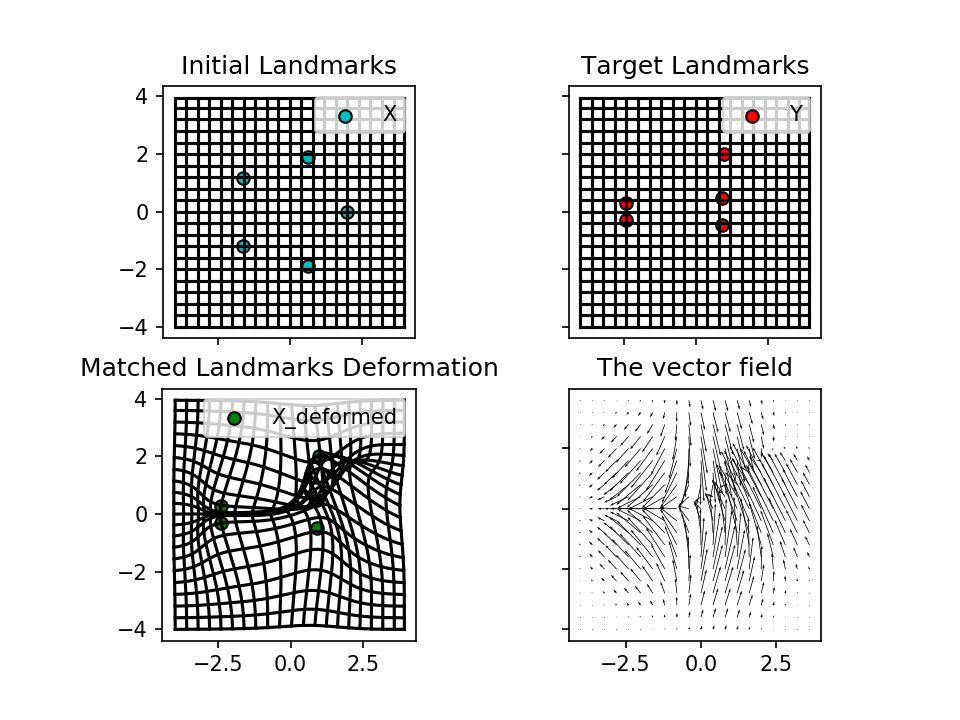

In [12]:
# N: number of landmarks
N = X.shape[1]

# Compute a kernel matrix
K = np.empty((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(X[:,i],X[:,j])
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()
# print('Lambda :', Lambda)

# deformed grid
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        for k_ in range(N):
            phiX0[i,j] += Lambda[0,k_]*k(p,X[:,k_])
            phiX1[i,j] += Lambda[1,k_]*k(p,X[:,k_])
# print(phiX0.shape)

# deform landmarks to target
X_deform0 = np.array(X[0])
X_deform1 = np.array(X[1])
for i in range(N):
    p = np.array([X[0,i],X[1,i]])
    for j in range(N):
        X_deform0[i] += Lambda[0,j]*k(p,X[:,j])
        X_deform1[i] += Lambda[1,j]*k(p,X[:,j])
X_deform = np.array([X_deform0, X_deform1])
# print(X_deform.shape)

f,ax = plt.subplots(2,2)
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

ss.plot_grid(phiX0,phiX1,ax=ax[1,0],rstride=stride,cstride=stride)
hx_deform = ax[1,0].scatter(X_deform[0,:],X_deform[1,:],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hx_deform],['X_deformed'],loc="upper right")
ax[1,0].set_title('Matched Landmarks Deformation')

ax[1,1].quiver(X0[::stride,::stride],X1[::stride,::stride],phiX0[::stride,::stride]-X0[::stride,::stride],
             phiX1[::stride,::stride]-X1[::stride,::stride],
             scale=stride)
ax[1,1].set_aspect('equal')
ax[1,1].set_title('The vector field')

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

# Note very obvious lack of invertibility at bottom left

### Do landmark LDDMM for case 2



In [13]:
# Do landmarks LDDMM
# parameters
sigma = 0.5 # feel free to try different parameters, e.g. 0.5 or 1 or 2
niter = 1000
epsilon = 2.0e-2

# initialize
T = 10 # Number of steps 
d,N = X.shape
a = np.zeros((d,N,T))
c = 1.0/2/sigma**2 # weighting
# make cost function only depends on momentum a
# print('Initial momentum :')
# print(a)

for it in range(niter):
    
    # Compute forward propagation
    Z = Compute_phi_forward(X,a)
    
    # Compute the final co-state by matching to target
    P_final = Compute_final_costate(Z[:,:,T],Y,c)
#     err = Y - Z[:,:,T]
#     EM = np.sum(err**2/(2.0*sigma**2))
#     print(EM)
    # Compute backward propagation
    P_inv = Compute_phi_backward(P_final,Z,a)
        
    # Compute the derivative of cost function over a
    da = Compute_dF_a(a,P_inv,Z)
    
    
    # Update a 
    a += -epsilon*da
    
    #
#     print('Iteration : ' + str(it))
#     print(a)

In [14]:
# Compute deformed landmarks over t
Z = Compute_phi_forward(X,a)
# print(Z)

# compute deformed grid flow over t
dx = 0.05
stride = 8
x0 = np.arange(-4,4,dx)
x1 = np.arange(-4,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
phiX0_t = np.array(X0)
phiX1_t = np.array(X1)

for t in range(T):
    for i in range(len(x0)):
        for j in range(len(x1)):
            # this point
            p = np.array([phiX0_t[i,j],phiX1_t[i,j]])
            for k_ in range(N):
                phiX0_t[i,j] += a[0,k_,t]*k(p,Z[:,k_,t])/T
                phiX1_t[i,j] += a[1,k_,t]*k(p,Z[:,k_,t])/T

<IPython.core.display.Javascript object>


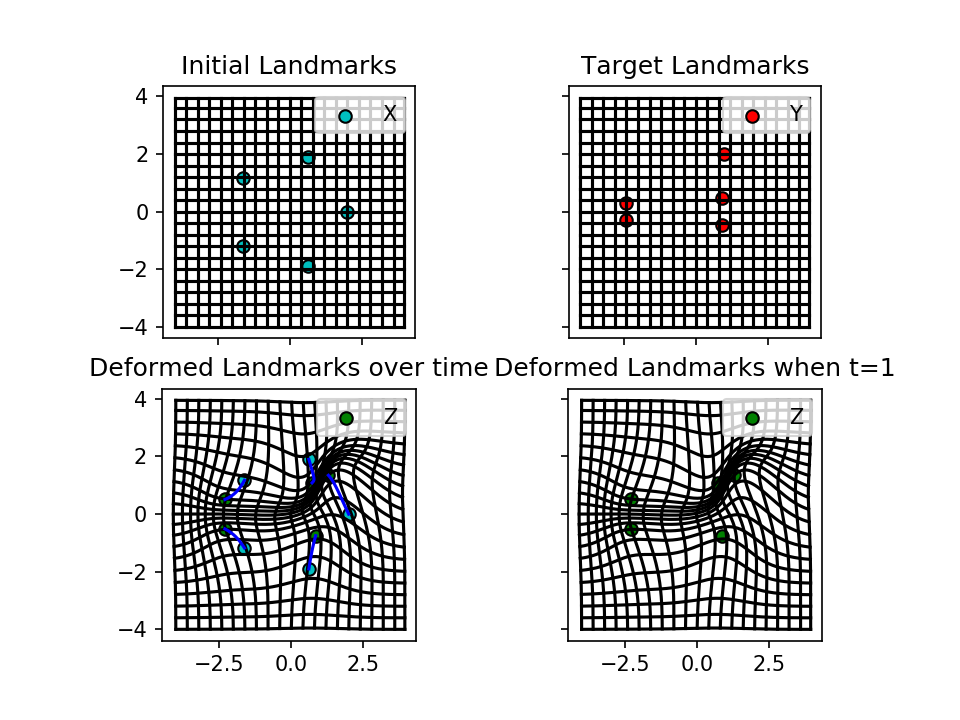

In [15]:
f,ax = plt.subplots(2,2)
# plot subject landmarks at t=0 (initial) 
ss.plot_grid(X0,X1,ax=ax[0,0],rstride=stride,cstride=stride)
hx = ax[0,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
ax[0,0].set_aspect('equal')
ax[0,0].legend([hx],['X'],loc="upper right")
ax[0,0].set_title('Initial Landmarks')

# plot target landmarks
ss.plot_grid(X0,X1,ax=ax[0,1],rstride=stride,cstride=stride)
hy = ax[0,1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0,1].set_aspect('equal')
ax[0,1].legend([hy],['Y'],loc="upper right")
ax[0,1].set_title('Target Landmarks')

# plot deformed subject landmarks trajectory
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,0],rstride=stride,cstride=stride) 
hx = ax[1,0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
for i in range(N):
    hz = ax[1,0].plot(Z[0,i,:],Z[1,i,:],color='b')
hz = ax[1,0].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,0].set_aspect('equal')
ax[1,0].legend([hz],['Z'],loc="upper right")
ax[1,0].set_title('Deformed Landmarks over time')

# plot deformed subjectlandmarks at t=T (final)
ss.plot_grid(phiX0_t,phiX1_t,ax=ax[1,1],rstride=stride,cstride=stride) 
hz = ax[1,1].scatter(Z[0,:,T],Z[1,:,T],color='g',edgecolor='k')
ax[1,1].set_aspect('equal')
ax[1,1].legend([hz],['Z'],loc="upper right")
ax[1,1].set_title('Deformed Landmarks when t=1')

plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
plt.show()

# Notice at the bottom left that the transformation is invertible!

## 3D Landmark case

In [24]:
sig = 5
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*sig**2))

# derative of kernel
def k_d1(x,y):
    v = np.exp(-np.sum((x-y)**2)/(2.0*sig**2))/(sig**2)
    return v

In [25]:
# now our 3D data
# daniel update
fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_landmarks.txt')
X = ss.load_landmarks(fname)
fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_surface.byu')
V0,F0 = ss.load_surface(fname)

# get a landmarks
fname = os.path.join('hipAmygLandmarks', 'hippocampus_02_landmarks.txt')
Y = ss.load_landmarks(fname)
fname = os.path.join('hipAmygLandmarks', 'hippocampus_02_surface.byu')
V1,F1 = ss.load_surface(fname)

In [32]:
## Do Landmark LDDMM

sigma = 0.1
niter = 200
epsilon = 1.0e-2

# initialize
T = 5 # Number of steps 
d,N = X.shape
a = np.zeros((d,N,T))
c = 1.0/2/sigma**2 # weighting
# make cost function only depends on momentum a
# print('Initial momentum :')
# print(a)

for it in range(niter):
    
    # Compute forward propagation
    Z = Compute_phi_forward(X,a)
    
    # Compute the final co-state by matching to target
    P_final = Compute_final_costate(Z[:,:,T],Y,c)
    
    # Compute backward propagation
    P_inv = Compute_phi_backward(P_final,Z,a)
    
    err = Y - Z[:,:,T]
    EM = np.sum(err**2/(2.0*sigma**2))
    print(EM)
    
    # Compute the derivative of cost function over a
    da = Compute_dF_a(a,P_inv,Z)
    
    # Update a 
    a += -epsilon*da
    
    #
#     print('Iteration : ' + str(it))
# print(a)


18745.069004454446
3519.512194760747
1923.4440755238365
1338.8379069971352
1025.8661340581907
829.6810021590018
694.8218665514803
596.4921039613309
521.7600458291685
463.1795401081916
416.14707144894606
377.65805237660874
345.6671688702824
318.7326844302917
295.80791435454336
276.1134420397945
259.05598023493934
244.1752653172656
231.1083492895333
219.56499547639356
209.31033381393192
200.15236948571305
191.9328044537352
184.5201661973771
177.8045748036833
171.6936956077881
166.10956541782727
160.98607359280578
156.26694190309738
151.90408986538333
147.85630188608553
144.0881334276516
140.5690083628655
137.27247056458341
134.17556082785168
131.25829626850194
128.50323395160325
125.89510406352429
123.42050072453269
121.0676207375072
118.82604232111319
116.68653728412968
114.64091123671697
112.6818673610118
110.8028900207471
108.99814511109537
107.26239456174787
105.59092282900866
103.97947356280586
102.42419492517956
100.92159227859848
99.46848716399786
98.06198165673008
96.699427329382

See the first landmark flow
[[  2.76668      2.75086986   2.70493425   2.62070297   2.49292792
    2.32066615]
 [-12.874966   -12.59972048 -12.32882049 -12.06101409 -11.79468086
  -11.52754429]
 [  5.969041     6.60469182   7.24121661   7.8780086    8.51416728
    9.14905577]]
[  2.76668  -12.874966   5.969041]
[  2.322447 -11.533189   9.142097]


<IPython.core.display.Javascript object>


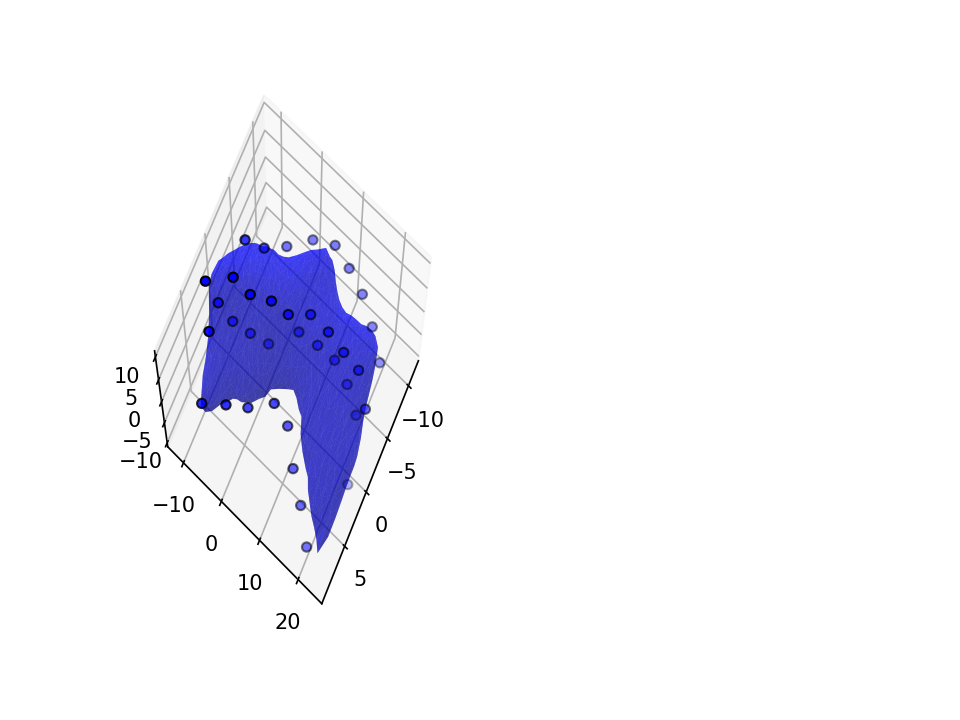

See the first Vertex flow
[[  2.201075   2.746996   2.746996 ...  -3.815504  -6.040216   1.809496]
 [ 21.125034  20.301912  19.125034 ...   8.625034  -5.874966 -10.825452]
 [ -3.815842  -3.733694  -3.184574 ...   4.187089   2.78061    1.883788]]
[[ -1.17164763  -0.0987475    0.67461056 ...  -5.12857231  -4.82205993
    1.11200044]
 [ 19.36914291  18.67469501  17.65333727 ...   7.37792917  -7.15237858
  -10.60953275]
 [ -6.58458273  -6.45389293  -5.79296809 ...   2.61946437   3.50902177
    4.30707367]]
Ending points difference
[[-0.00178085  0.09394672  0.0907967  -0.03568425 -0.08368007  0.00341242
  -0.10921168  0.05348767  0.19561238 -0.03795882  0.11796653 -0.05744293
  -0.24369655  0.03085988 -0.09052295  0.02349079  0.33183459 -0.01413022
   0.01900408  0.04594241 -0.20419572 -0.08307455  0.15636903 -0.04758615
   0.0580308   0.10757556 -0.21955643  0.03464325  0.09784435 -0.09772182
   0.23692278 -0.00365079 -0.10819509  0.06140158 -0.14352895  0.08092759
   0.04672376 -0.041162

In [33]:
# Compute deformed landmarks over t
Z = Compute_phi_forward(X,a)
print("See the first landmark flow")
print(Z[:,0,:])
print(X[:,0])
print(Y[:,0])

f = plt.figure()
ax = f.add_subplot(1,2,1,projection='3d')
# ax.cla()
# ax.scatter(Z[0,:,0],Z[1,:,0],Z[2,:,0],color='b',edgecolor='k')
# ax.plot_trisurf(V0[0,:],V0[1,:],V0[2,:],triangles=F0,color='b',alpha=0.5)    
# f.canvas.draw()
# raise Exception

# calculate the deformed vertices of our triangulated surface
# these vertices are deformed smoothly based on the landmarks that they are close to
# so we expect the deformed template surface to look similar to the target surface
phiV0 = np.array(V0)
# print(V0.shape)
dt = 1.0/T
for t in range(T):
    phiV0dot = np.zeros_like(phiV0)
    for i in range(len(phiV0[0])):
            # this point
            for k_ in range(N):
                phiV0dot[:,i] += a[:,k_,t]*k(phiV0[:,i],Z[:,k_,t])
    # update using Euler's method
    phiV0 += phiV0dot*dt
    
    ax.cla()
    ax.scatter(Z[0,:,t+1],Z[1,:,t+1],Z[2,:,t+1],color='b',edgecolor='k')
    ax.plot_trisurf(phiV0[0,:],phiV0[1,:],phiV0[2,:],triangles=F0,color='b',alpha=0.5)    
    f.canvas.draw()
print("See the first Vertex flow")
print(V0)
print(phiV0)


print("Ending points difference")
print((Z[:,:,T]-Y))



In [51]:
print(V0.shape)

(3, 625)


In [34]:
# print(V0[:,1].shape)
# print(N)
# print(V0)
# print(phiV0)
print( np.transpose(np.array(phiV0[:,i])))
print( V0.shape)
# # Compute deformed landmarks over t
# Z = Compute_phi_forward(X,a)
# # print(Z)

# # compute deformed grid flow over t
# dx = 0.05
# stride = 8
# x0 = np.arange(-4,4,dx)
# x1 = np.arange(-4,4,dx)
# X0,X1 = np.meshgrid(x0,x1,indexing='ij')
# phiX0_t = np.array(X0)
# phiX1_t = np.array(X1)

# for t in range(T):
#     for i in range(len(x0)):
#         for j in range(len(x1)):
#             # this point
#             p = np.array([phiX0_t[i,j],phiX1_t[i,j]])
#             for k_ in range(N):
#                 phiX0_t[i,j] += a[0,k_,t]*k(p,Z[:,k_,t])/T
#                 phiX1_t[i,j] += a[1,k_,t]*k(p,Z[:,k_,t])/T

[  1.11200044 -10.60953275   4.30707367]
(3, 625)


<IPython.core.display.Javascript object>


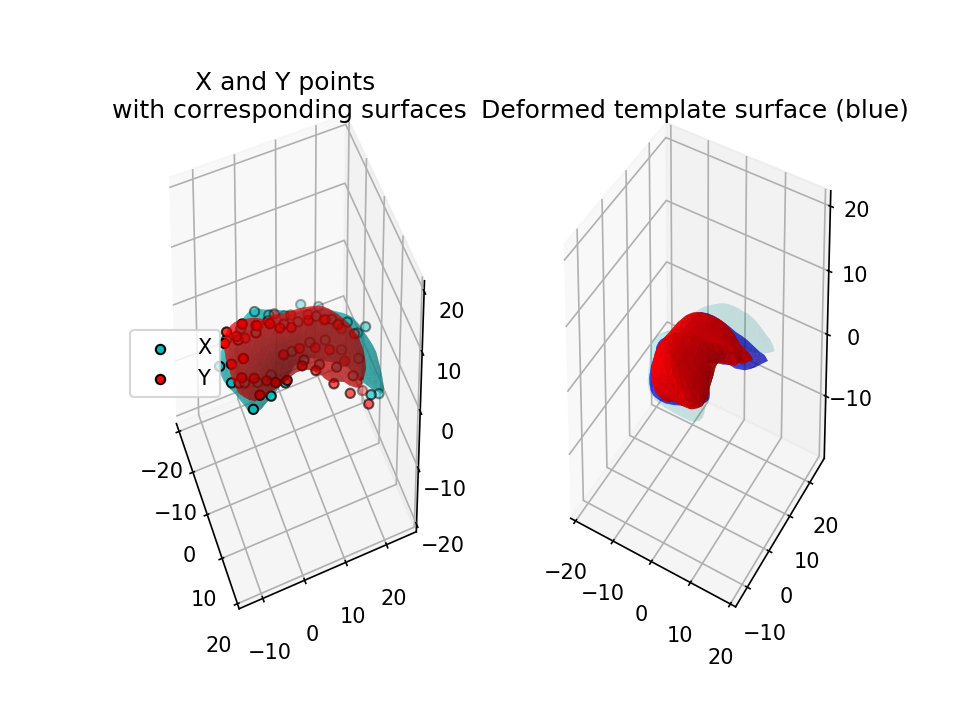

Text(0.5,0.92,'Deformed template surface (blue)')

In [37]:
# plot our results
f = plt.figure()
ax = f.add_subplot(1,2,1,projection='3d')
ax.plot_trisurf(V0[0,:],V0[1,:],V0[2,:],triangles=F0,color='c',alpha=0.5)
hx = ax.scatter(X[0,:],X[1,:],X[2,:],color='c',edgecolor='k')
ax.plot_trisurf(V1[0,:],V1[1,:],V1[2,:],triangles=F1,color='r',alpha=0.5)
hy = ax.scatter(Y[0,:],Y[1,:],Y[2,:],color='r',edgecolor='k')
ax.legend([hx,hy],['X','Y'],loc=6)
ss.axis_equal(ax)
ax.set_title('X and Y points \nwith corresponding surfaces')

ax = f.add_subplot(1,2,2,projection='3d')
ax.plot_trisurf(V0[0,:],V0[1,:],V0[2,:],triangles=F0,color='c',alpha=0.1)
ax.plot_trisurf(phiV0[0,:],phiV0[1,:],phiV0[2,:],triangles=F0,color='b',alpha=0.5)
ax.plot_trisurf(V1[0,:],V1[1,:],V1[2,:],triangles=F1,color='r',alpha=0.9)

# hx = ax.scatter(X[0,:],X[1,:],X[2,:],color='c',edgecolor='k')
# hx = ax.scatter(Z[0,:,T],Z[1,:,T],Z[2,:,T],color='b',edgecolor='k')
# hy = ax.scatter(Y[0,:],Y[1,:],Y[2,:],color='r',edgecolor='k')
ss.axis_equal(ax)
ax.set_title('Deformed template surface (blue)')

